In [4]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import pickle
import matplotlib.patches as mpatches
import pandas as pd
import matplotlib
import matplotlib as mpl
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os
import seaborn as sns
import scipy
from matplotlib import cm

%matplotlib inline

import plotting_functions

from tsne_plotting_functions import plot_continuous_tsne, plot_categorical_tsne


## Functions

In [5]:
path_to_transformations = "/homes/gws/nbbwang/AD_project/NEW_FULL_PIPELINE/temp_gpu_storage/consensus_interpretation/"
path_to_saved_tsne_embeddings = "/homes/gws/nbbwang/AD_project/NEW_FULL_PIPELINE/temp_gpu_storage/tSNE_embeddings_shareable/"
path_to_mdad_data = "/homes/gws/nbbwang/AD_project/NEW_FULL_PIPELINE/temp_gpu_storage/MTL_data/origGE/"
path_to_gs_data = "/homes/gws/nbbwang/AD_project/NEW_FULL_PIPELINE/fgsea/data/"

In [15]:
os.listdir(path_to_mdad_data)

['ACT_MSBBRNA_ROSMAP.h5',
 'ACT_MSBBRNA_ROSMAP_PCA.h5',
 'ACT_MSBBRNA_ROSMAP_PCASplit',
 '.ipynb_checkpoints']

In [7]:
phen_df = pd.read_csv("/homes/gws/nbbwang/AD_project/NEW_FULL_PIPELINE/temp_gpu_storage/tSNE_embeddings_shareable/phenotype_labels.csv", index_col=0)
pred_pathology_path = "/homes/gws/nbbwang/AD_project/NEW_FULL_PIPELINE/temp_gpu_storage/predictions/MTL/ACT_MSBBRNA_ROSMAP_PCA/200_relu_[500, 100]_[50, 10]_0.100000_0.001000_0.001000_[1, 1]_0.100000_20/CONSENSUS_PREDICTIONS.csv"

In [8]:
phenotypes = ["CERAD", "BRAAK", "PLAQUES", "TANGLES", "ABETA_IHC", "TAU_IHC"]


# LOAD EXPRESSION DATA 
num_components=500
with h5py.File(path_to_mdad_data + "ACT_MSBBRNA_ROSMAP_PCA.h5", 'r') as hf:
    print(list(hf.keys()))
    X_GE_PCA = hf["ge_transformed"][:,:500]
    Y = hf["labels"][:]
    labels_names= hf["labels_names"][:].astype(str)
labels_df = pd.DataFrame(Y, columns=labels_names.astype(str), dtype="str")


with h5py.File(path_to_mdad_data + "ACT_MSBBRNA_ROSMAP.h5", 'r') as hf:
    print(list(hf.keys()))
    X_GE = hf["ge"][:]
    gene_symbols = hf["gene_symbols"][:].astype(str)
ge_df = pd.DataFrame(X_GE, columns=gene_symbols)




path_to_gs_data = "/homes/gws/nbbwang/AD_project/NEW_FULL_PIPELINE/fgsea/data/"
gmt_locations = {"REACTOME": path_to_gs_data + 'c2.all.v7.0.symbols_JustR.gmt',
                "KEGG": path_to_gs_data + 'c2.all.v7.0.symbols_JustK.gmt',
                "HALLMARK": path_to_gs_data + 'h.all.v7.0.symbols.gmt'}
for gset in ["mathys_celltypes", "sara_modules", "ben_modules", "mathys_microglia", "zhang_modules"]:
    gmt_locations[gset] = '%s%s/processed/gene_set.gmt'%(path_to_gs_data,gset)
    

['PCA_components_', 'ge_transformed', 'gene_symbols', 'labels', 'labels_names']
['ge', 'gene_symbols', 'labels', 'labels_names']


In [9]:

# example:   load_transformations("MTL", "consensus", "normed_KMeans", 1, None)
# example:   load_transformations("MTL", "single_run", 0, 1, None)
# example:   load_transformations("MLP", "single_run", 0, 1, "CERAD")

def load_transformations(embedding_source, METHOD, method_specifier, hidden_layer, METHOD_PHENOTYPE):
    
    if METHOD == "single_run":
        if embedding_source == "MTL":
            path = path_to_transformations + "/model_transformations/MTL/%i/%i.txt"%(hidden_layer, method_specifier)
        else:
            path = path_to_transformations + "/model_transformations/MLP/%s/%i/%i.txt"%(METHOD_PHENOTYPE, hidden_layer, method_specifier)
        return (np.loadtxt(path))
    elif METHOD == "consensus":
        path = path_to_transformations + "clusters/%i/%s/%s_50.p"%(hidden_layer, method_specifier, embedding_source)
        with open(path, "rb") as f:
            [embedding, assigned_clusters, consensus_model] = pickle.load(f)
        return embedding
    

def calculate_unsupervised_transformations(X_GE_PCA, METHOD, dimensions):
    
    if METHOD == "KMeans":
        def kmeans_centroids_for_test(X_GE_PCA, cluster_labels):
            n_clusters = len(np.unique(cluster_labels))
            n,d = X_GE_PCA.shape

            new_centroids = np.zeros([n_clusters,n])
            for i in range(n_clusters):
                new_centroids[i] = np.mean(X_GE_PCA.T[np.where(cluster_labels ==i)], axis=0).reshape([1,-1])

            return new_centroids


        kmeans = KMeans(n_clusters=dimensions).fit(X_GE_PCA.T)
        X = kmeans_centroids_for_test(X_GE_PCA, kmeans.labels_).T

    elif METHOD == "PCA":
        pca = PCA(n_components = dimensions)
        pca.fit(X_GE_PCA)
        X = pca.transform(X_GE_PCA)[:, :dimensions]
    return X



def generate_geneset_embeddings(ge_df, gmt_file):
    gmt = pd.read_csv(gmt_file, header=None)
    gmt["names"] = gmt[0].apply(lambda x: x.split("\t")[0])
    gmt["genes"] = gmt[0].apply(lambda x: x.split("\t")[2:])
    
    ge_gset_df = pd.DataFrame(index=ge_df.index)
    
    for gset_i,row in gmt.iterrows():
        name = row["names"]
        genes_in_gs = np.intersect1d(np.array(row["genes"]), gene_symbols)
        ge_gset_df[name] = np.mean(ge_df[genes_in_gs],axis=1)
        
    return(ge_gset_df)



In [10]:
# READ IN PREDICTED PATHOLOGY (and resilience)
pred_pathology_df = pd.read_csv(pred_pathology_path)
pred_pathology_df = pred_pathology_df.merge(phen_df[["sample_name", "dementia", "age_censored"]], how="inner")

def scale_to_cat(X, val_min, val_max):
    cat_vals = [1/val_max*x for x in range(val_max+1)]
    dists = [[np.abs(v-cv) for cv in cat_vals] for v in X]
    cats = [np.argmin(v) for v in dists]
    return(np.array(cats).astype(float))

for phen in ["CERAD", "BRAAK"]:
    maxval = int(np.nanmax(phen_df[phen].values.astype(float)))
    pred_pathology_df[phen] = scale_to_cat(pred_pathology_df[phen].values, 0, maxval)
    

phen_df = phen_df.merge(pred_pathology_df[["sample_name"] + phenotypes],
             on=["sample_name"], how="left", suffixes=("", "_PRED"))

In [11]:
# example:   load_transformations("MTL", "consensus", "normed_KMeans", 1, None)
# example:   load_transformations("MTL", "single_run", 0, 1, None)

MTL 1 normed_KMeans_medioids None
loaded embedding
MLP 1 0 CERAD
loaded embedding
MLP 1 0 BRAAK
loaded embedding


/homes/gws/nbbwang/MD-AD_public/Paper_Analyses/tsne_plotting_functions.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(2,1,figsize=(4, 5), gridspec_kw = {'height_ratios':[10, 1]})
/homes/gws/nbbwang/MD-AD_public/Paper_Analyses/tsne_plotting_functions.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1,1,figsize=(4, 4))


MLP 1 0 PLAQUES
loaded embedding
MLP 1 0 TANGLES
loaded embedding
MLP 1 0 ABETA_IHC
loaded embedding
MLP 1 0 TAU_IHC
loaded embedding
modules 1 zhang_modules None
loaded embedding
modules 1 sara_modules None
loaded embedding
modules 1 ben_modules None
loaded embedding
PCA 1 0 None
loaded embedding


/homes/gws/nbbwang/MD-AD_public/Paper_Analyses/tsne_plotting_functions.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(2,1,figsize=(4, 5), gridspec_kw = {'height_ratios':[10, 1]})
/homes/gws/nbbwang/MD-AD_public/Paper_Analyses/tsne_plotting_functions.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1,1,figsize=(4, 4))


KMeans 1 0 None
loaded embedding


/homes/gws/nbbwang/MD-AD_public/Paper_Analyses/tsne_plotting_functions.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(2,1,figsize=(4, 5), gridspec_kw = {'height_ratios':[10, 1]})
/homes/gws/nbbwang/MD-AD_public/Paper_Analyses/tsne_plotting_functions.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1,1,figsize=(4, 4))


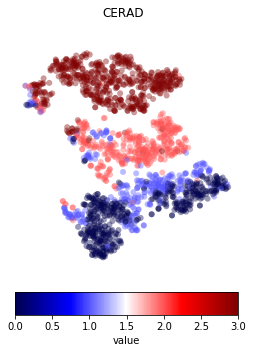

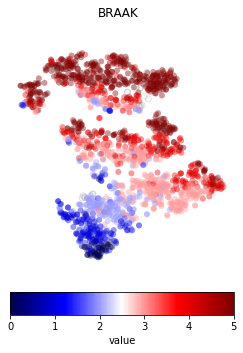

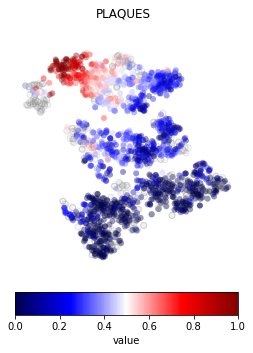

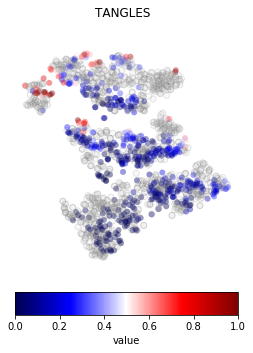

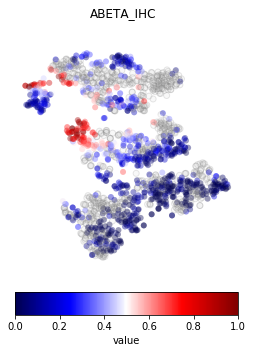

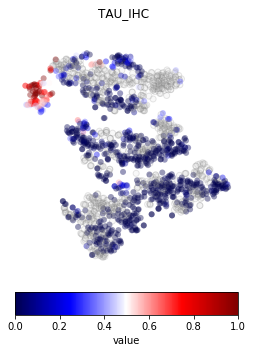

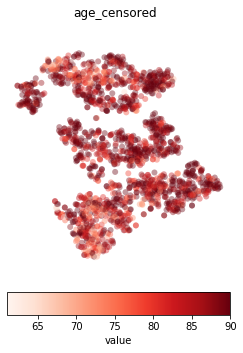

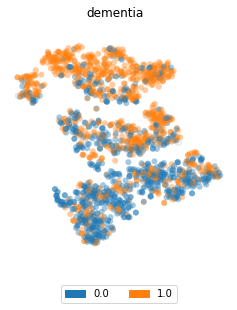

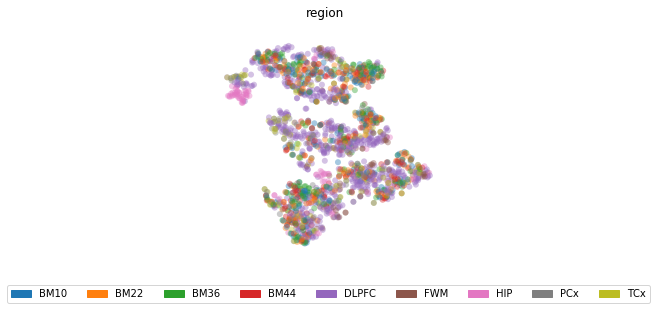

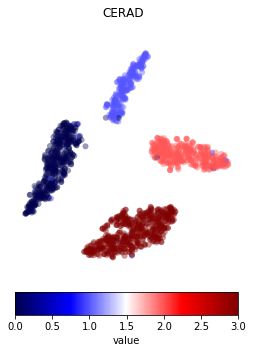

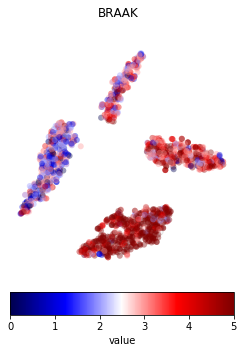

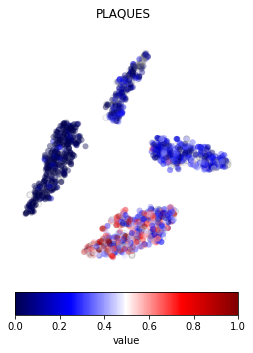

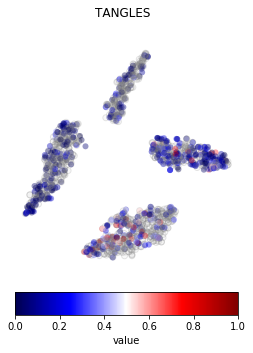

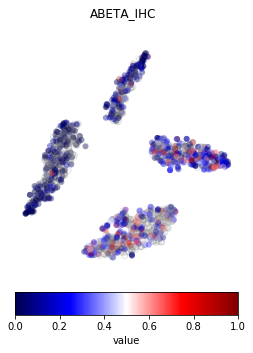

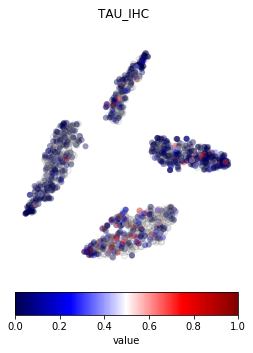

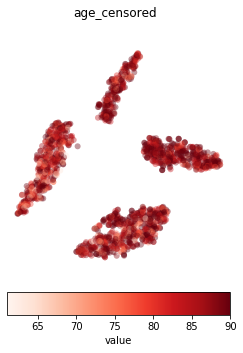

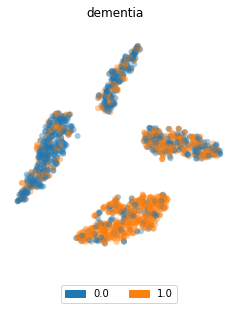

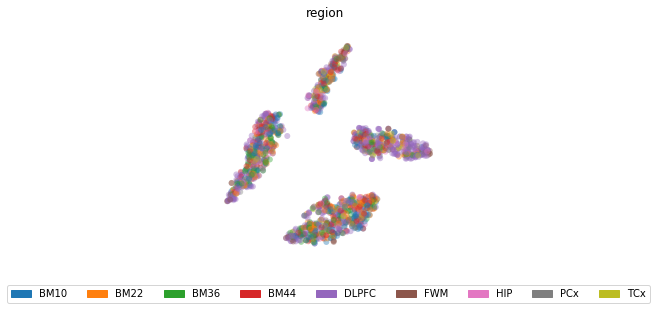

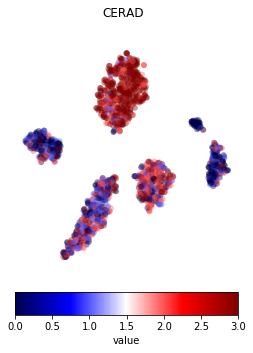

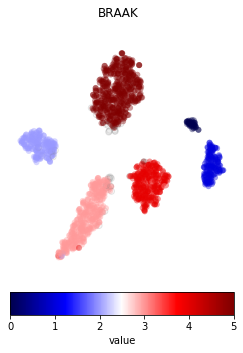

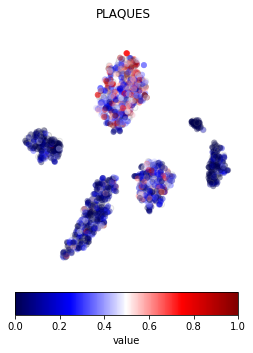

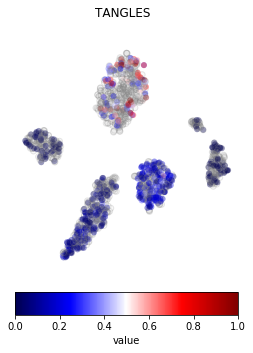

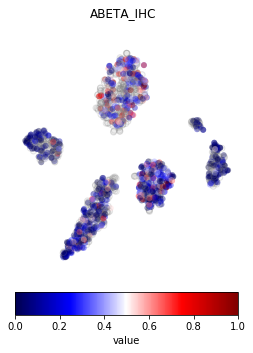

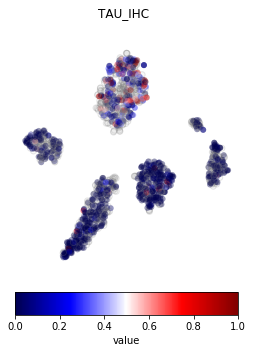

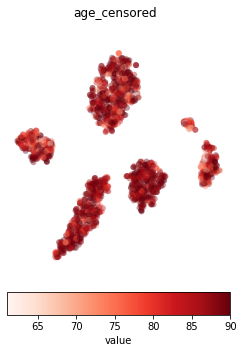

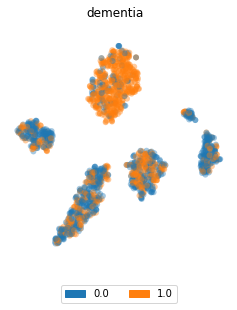

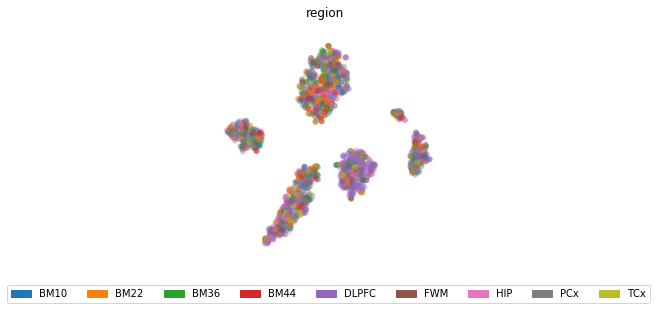

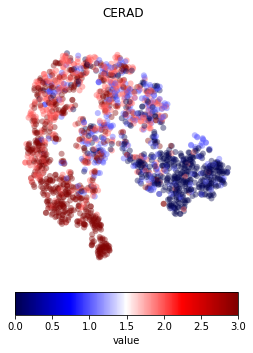

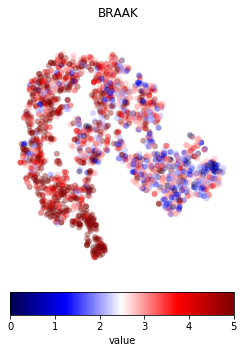

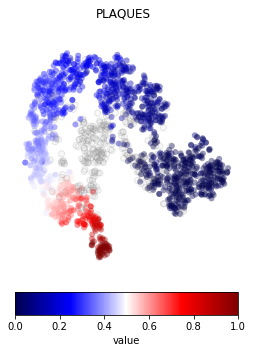

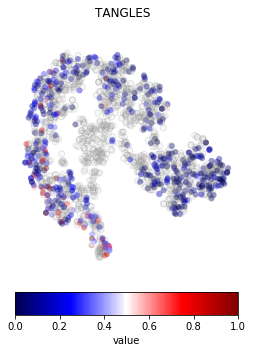

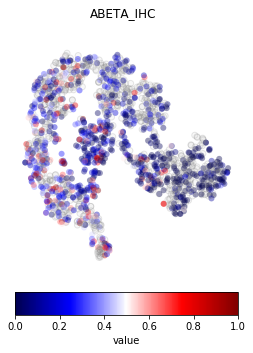

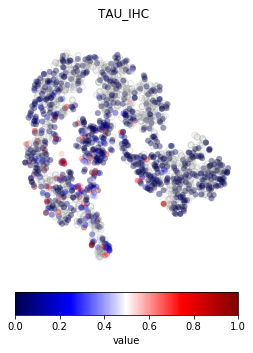

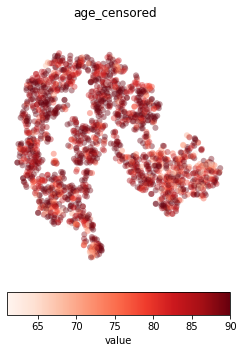

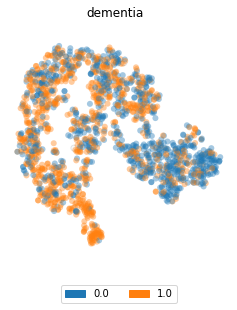

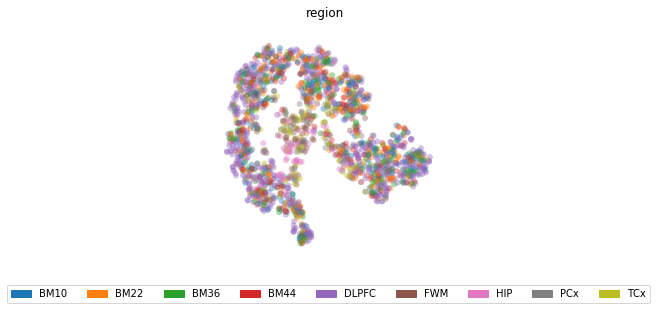

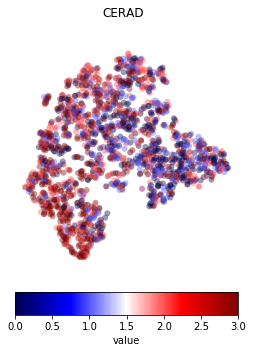

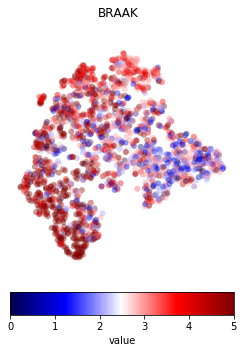

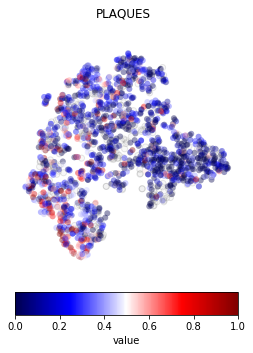

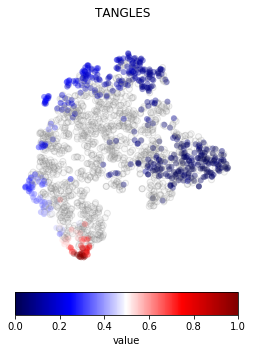

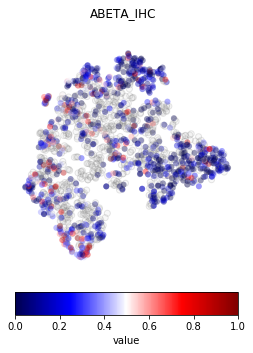

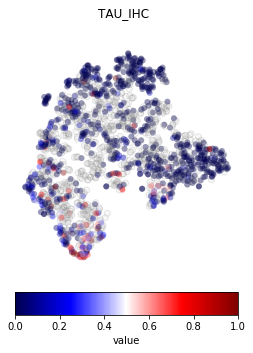

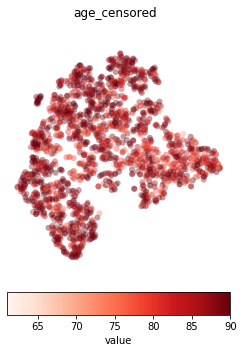

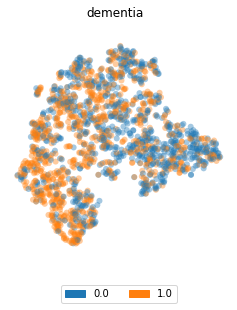

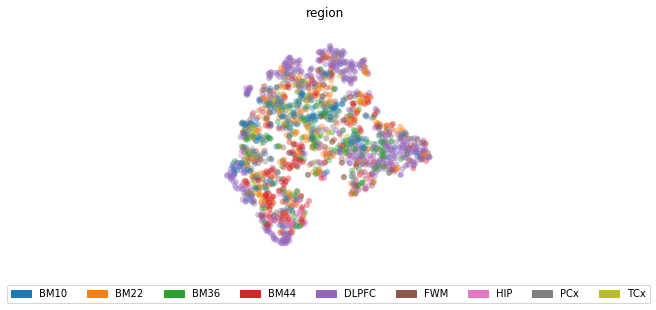

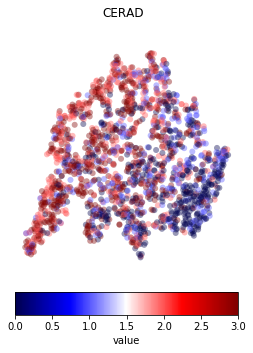

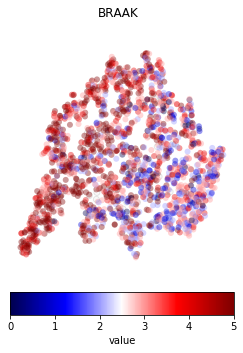

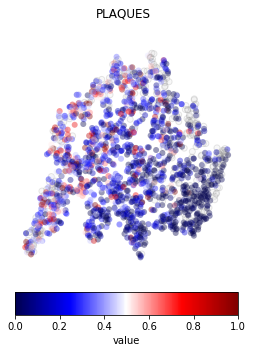

In [ ]:
calc_new = False
nangray = True
consensus=True
unsupervised_dim = 50
# for method in ["modules"]:

for method in ["MTL", "MLP", "modules", "PCA", "KMeans"]:
    for hidden_layer in [1]:
        
        if method=="MLP":
            # phens_to_check refers to whether there are different embeddings generated for different phenotypes (i.e., MLPs)
            phens_to_check = phenotypes
        else:
            phens_to_check = [None]
        
        
        for phenotype in phens_to_check:
            if consensus and method=="MTL":
                specifics = ["normed_KMeans_medioids"]
            elif method == "modules":
                specifics = ["zhang_modules", "sara_modules", "ben_modules"]
            else:
                specifics = [0]

            for specific in specifics:
                if method in ["PCA", "KMeans"]:
                    X = calculate_unsupervised_transformations(X_GE_PCA, method, unsupervised_dim)
                    savefolder = "Figures/%s/%i/"%(method, unsupervised_dim)
                elif method == "modules":
                    X = generate_geneset_embeddings(ge_df, gmt_locations[specific]).values
                    savefolder = "Figures/%s/%s/"%(method, specific)
                else:
                    if consensus and method=="MTL":
                        subfolder = "consensus"
                    else:
                        subfolder = "single_run"
                    
                    X = load_transformations(method, subfolder, specific, hidden_layer, phenotype)
                    
                    if method=="MLP":
                        savefolder = "Figures/%s/%s/%i/%s/"%(method, phenotype,  hidden_layer, specific)
                    else:
                        savefolder = "Figures/%s/%i/%s/%s/"%(method, hidden_layer, subfolder, specific)

                print(method, hidden_layer, specific, phenotype)
                random_order = np.random.permutation(len(X))                    

                if calc_new:
                    print(X.shape)
                    tsne = TSNE(n_components=2, perplexity=30)
                    E = tsne.fit_transform(X)

                    os.makedirs(os.path.dirname(savefolder), exist_ok=True)
                    with h5py.File(path_to_saved_tsne_embeddings + savefolder + "embedded_data.h5", 'w') as hf:
                        hf.create_dataset("E", data=E)
    #           otherwise, load in a previously calculated embedding
                else:
                    with h5py.File(path_to_saved_tsne_embeddings + savefolder + "embedded_data.h5", 'r') as hf:
                        E = hf["E"][:]
                    print ("loaded embedding")

                E = E[random_order]

                if nangray:
                    savefolder += "nangray/"             

                for i,phen in enumerate(phenotypes + ["age_censored", "dementia", "region"]):
                    phens = phen_df[phen].values[random_order]
                    phens_s = phens.astype(str)

                    if len(np.unique(phens_s[phens_s != "nan"])) < 4 or phen in ["apoe_genotype", "region"]:
                        plot_categorical_tsne(E, phens, phen, "tab10", nangray, save_path=None)
                    
                    elif phen == "age_censored":
                        plot_continuous_tsne(E, phens, phen, matplotlib.cm.Reds, nangray, save_path=None)

                    else:
                        plot_continuous_tsne(E, phens, phen, matplotlib.cm.seismic, nangray, save_path=None)